<a href="https://colab.research.google.com/github/micah-shull/pipelines/blob/main/pipelines_16_ensemble_02_stacking_06_weighted_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Load & Preprocess Data

1.3.2


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


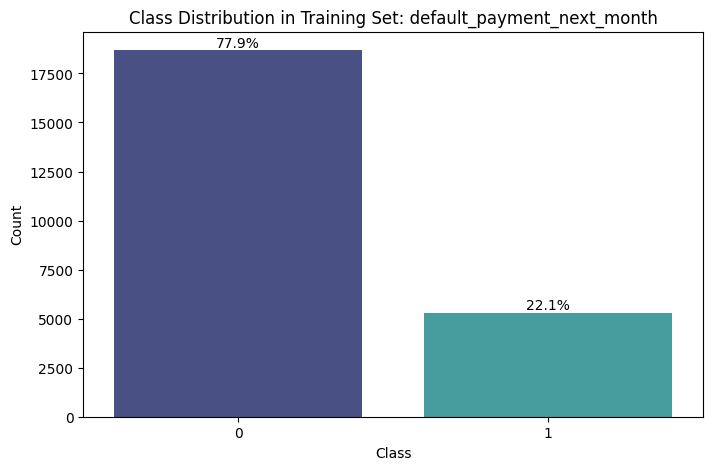

In [1]:
import sklearn
print(sklearn.__version__)
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from loan_data_utils import load_and_preprocess_data, plot_class_distribution
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier

# Load and preprocess data (assuming this function is defined)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']
target = 'default_payment_next_month'

# load and preprocess data
X, y = load_and_preprocess_data(url, categorical_columns, target)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['category']).columns.tolist()

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(drop='first'))
        ]), categorical_features)
    ])

plot_class_distribution(y_train, target)

### Weighted Model Approach

In [3]:
import joblib
import json
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, classification_report
from sklearn.ensemble import VotingClassifier
from loan_data_utils import load_and_preprocess_data

# Define class weights
class_weight = {0: 1, 1: 3}
scale_pos_weight = 3

# Define candidate models with weights
candidate_models = {
    'LogReg': LogisticRegression(random_state=42, class_weight=class_weight, max_iter=1000),
    'RF': RandomForestClassifier(random_state=42, class_weight=class_weight),
    'LGBM': LGBMClassifier(random_state=42, scale_pos_weight=scale_pos_weight)
}

# Create pipelines for each candidate model
pipelines = {name: Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
             for name, model in candidate_models.items()}

# Load the previous best models and parameters
best_models = joblib.load('best_models.pkl')
with open('best_params.json', 'r') as json_file:
    best_params = json.load(json_file)

# Update models with weights
for metric, model in best_models.items():
    model_name = model.named_steps['classifier'].__class__.__name__

    if model_name == 'LGBMClassifier':
        model.named_steps['classifier'].set_params(scale_pos_weight=scale_pos_weight)
        best_params[metric]['classifier__scale_pos_weight'] = scale_pos_weight
    elif model_name in ['LogisticRegression', 'RandomForestClassifier']:
        model.named_steps['classifier'].set_params(class_weight=class_weight)
        best_params[metric]['classifier__class_weight'] = class_weight

# Save the updated models and parameters
joblib.dump(best_models, 'best_models_weighted.pkl')
with open('best_params_weighted.json', 'w') as json_file:
    json.dump(best_params, json_file, indent=4)

# Create a list of (name, model) tuples for the VotingClassifier
estimators = [
    ('recall_class_1', best_models['recall_class_1']),
    ('precision_class_1', best_models['precision_class_1']),
    ('recall_class_0', best_models['recall_class_0']),
    ('precision_class_0', best_models['precision_class_0'])
]

# Initialize the VotingClassifier with the best models
voting_clf = VotingClassifier(estimators=estimators, voting='soft')

# Fit the VotingClassifier on the training data
voting_clf.fit(X_train, y_train)

# Save the updated VotingClassifier model
joblib.dump(voting_clf, 'voting_classifier_weighted.pkl')

print("Updated VotingClassifier model saved to 'voting_classifier_weighted.pkl'")

# Load the optimal thresholds from the file
with open('optimal_thresholds.json', 'r') as json_file:
    optimal_thresholds = json.load(json_file)

# Function to apply class-specific thresholds
def predict_with_class_specific_thresholds(model, X, threshold_class_1, threshold_class_0):
    y_proba = model.predict_proba(X)
    y_pred = np.zeros(y_proba.shape[0])

    # Apply thresholds to obtain predictions
    y_pred[(y_proba[:, 1] >= threshold_class_1)] = 1  # Predict class 1 for probabilities above threshold_class_1
    y_pred[(y_proba[:, 0] >= threshold_class_0)] = 0  # Predict class 0 for probabilities above threshold_class_0

    return y_pred

# Predict with the updated VotingClassifier model using the optimal thresholds
threshold_class_1 = optimal_thresholds['threshold_class_1']
threshold_class_0 = optimal_thresholds['threshold_class_0']

y_pred_voting = predict_with_class_specific_thresholds(voting_clf, X_test, threshold_class_1, threshold_class_0)

# Evaluate the performance of the VotingClassifier
recall_1 = recall_score(y_test, y_pred_voting, pos_label=1)
precision_1 = precision_score(y_test, y_pred_voting, pos_label=1, zero_division=0)
recall_0 = recall_score(y_test, y_pred_voting, pos_label=0)
precision_0 = precision_score(y_test, y_pred_voting, pos_label=0, zero_division=0)
f1_macro = f1_score(y_test, y_pred_voting, average='macro')
accuracy = accuracy_score(y_test, y_pred_voting)

# Print the evaluation metrics
print(f'Recall Class 1: {recall_1:.4f}')
print(f'Precision Class 1: {precision_1:.4f}')
print(f'Recall Class 0: {recall_0:.4f}')
print(f'Precision Class 0: {precision_0:.4f}')
print(f'F1 Macro: {f1_macro:.4f}')
print(f'Accuracy: {accuracy:.4f}')

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_voting))


[LightGBM] [Info] Number of positive: 5309, number of negative: 18691
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3276
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 5309, number of negative: 18691
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001860 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3276
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightG

### Analysis of the Classification Reports

1. **Precision and Recall for Class 0**:
   - **Current**: Lower recall (0.55) compared to the previous model (0.87). This indicates more false negatives for class 0.
   - **Previous**: Higher precision (0.99) and recall (0.87), indicating fewer false positives and false negatives for class 0.

2. **Precision and Recall for Class 1**:
   - **Current**: Lower precision (0.33) compared to the previous model (0.68). This indicates more false positives for class 1.
   - **Previous**: Higher recall (0.95) and precision (0.68), indicating better performance in identifying class 1 correctly.

3. **Overall Performance**:
   - **Current**: The overall performance metrics (accuracy, macro F1-score, and weighted F1-score) are significantly lower compared to the previous best model.

### Recommendations:

The weighted approach significantly impacted the overall performance, resulting in a notable drop in accuracy and F1-scores. Given the results, it's clear that the previous model performs better.

### Next Steps:

1. **Revert to the Previous Best Model**:
   - Since the previous model achieved better performance metrics, reverting to it seems the best course of action.
   - Use the previous best-performing model without the added weights, as it maintained higher precision, recall, and overall accuracy.

2. **Explore Resampling Techniques**:
   - To address class imbalance, consider using resampling techniques such as SMOTE (Synthetic Minority Over-sampling Technique) or ADASYN (Adaptive Synthetic Sampling).
   - These techniques can help balance the class distribution by generating synthetic samples for the minority class.

